## Data Cleaning

In [1]:
import findspark

findspark.init()

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("data_cleaning").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/13 22:28:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/13 22:28:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


In [3]:
from pyspark import SparkFiles
df = spark.read.csv("credit_card_transactions.csv", header=True, inferSchema=True) #filepath hardcoded to local for now, change to hadoop later?

In [4]:
from pyspark.sql.functions import radians, cos, sin, asin, sqrt

# Convert lat/long to radians
df = df.withColumn("lat_rad", radians("lat")) \
       .withColumn("long_rad", radians("long")) \
       .withColumn("merch_lat_rad", radians("merch_lat")) \
       .withColumn("merch_long_rad", radians("merch_long"))

# Haversine formula in PySpark
df = df.withColumn("home_merchant_dist", 6371 * 2 * asin(sqrt(
    sin((df["merch_lat_rad"] - df["lat_rad"]) / 2) ** 2 +
    cos(df["lat_rad"]) * cos(df["merch_lat_rad"]) *
    sin((df["merch_long_rad"] - df["long_rad"]) / 2) ** 2
)))


In [5]:
df = df.drop("lat_rad", "long_rad", "merch_lat_rad", "merch_long_rad")

In [6]:
df.select("home_merchant_dist").describe().show()

[Stage 2:============================================>              (3 + 1) / 4]

+-------+--------------------+
|summary|  home_merchant_dist|
+-------+--------------------+
|  count|             1296675|
|   mean|   76.11465060395075|
| stddev|  29.116934511278078|
|    min|0.022254515638533652|
|    max|  152.11717310595034|
+-------+--------------------+



In [7]:
from pyspark.sql.functions import hour, dayofweek, month, to_timestamp

df = df.withColumn("trans_timestamp", to_timestamp("trans_date_trans_time"))
df = df.withColumn("transaction_hour", hour("trans_timestamp"))
df = df.withColumn("transaction_dayofweek", dayofweek("trans_timestamp"))
df = df.withColumn("transaction_month", month("trans_timestamp"))


In [8]:
df.show(5, truncate=False)

25/04/13 22:30:54 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+---------------------+----------------+----------------------------------+-------------+------+---------+-------+------+----------------------------+--------------+-----+-----+-------+---------+--------+---------------------------------+----------+--------------------------------+----------+------------------+-----------+--------+-------------+------------------+-------------------+----------------+---------------------+-----------------+
|Unnamed: 0|trans_date_trans_time|cc_num          |merchant                          |category     |amt   |first    |last   |gender|street                      |city          |state|zip  |lat    |long     |city_pop|job                              |dob       |trans_num                       |unix_time |merch_lat         |merch_long |is_fraud|merch_zipcode|home_merchant_dist|trans_timestamp    |transaction_hour|transaction_dayofweek|transaction_month|
+----------+---------------------+----------------+----------------------------------+----

In [9]:
# Clear missing values
df_cleaned = df.dropna()



In [10]:
print(f"Original DataFrame count: {df.count()}")
print(f"Cleaned DataFrame count: {df_cleaned.count()}")


Original DataFrame count: 1296675


[Stage 9:>                                                          (0 + 4) / 4]

Cleaned DataFrame count: 1100702


In [11]:
from pyspark.sql.functions import col, rand

# Separate the fraud and legit DataFrames
df_fraud = df_cleaned.filter(col('is_fraud') == 1)
df_legit = df_cleaned.filter(col('is_fraud') == 0)

# Calculate the fraction for downsampling
fraction = df_fraud.count() / df_legit.count()

# Downsample the legit class to match the fraud class size
df_legit_downsampled = df_legit.sample(fraction=fraction, seed=101)

# Union the fraud and downsampled legit DataFrames
df_balanced = df_fraud.union(df_legit_downsampled)

# Shuffle the balanced DataFrame by adding a random column and sorting by it
df_balanced = df_balanced.withColumn("rand_col", rand())  # Add a random column
df_balanced = df_balanced.orderBy("rand_col")  # Shuffle the rows based on the random column

# Drop the random column after shuffling
df_balanced = df_balanced.drop("rand_col")

# Show the shuffled balanced dataframe
df_balanced.show()

# Optionally, get the count of the balanced DataFrame
print(f"Balanced DataFrame count: {df_balanced.count()}")

+----------+---------------------+-------------------+--------------------+-------------+-------+--------+--------+------+--------------------+----------------+-----+-----+-------+---------+--------+--------------------+----------+--------------------+----------+------------------+-----------+--------+-------------+------------------+-------------------+----------------+---------------------+-----------------+
|Unnamed: 0|trans_date_trans_time|             cc_num|            merchant|     category|    amt|   first|    last|gender|              street|            city|state|  zip|    lat|     long|city_pop|                 job|       dob|           trans_num| unix_time|         merch_lat| merch_long|is_fraud|merch_zipcode|home_merchant_dist|    trans_timestamp|transaction_hour|transaction_dayofweek|transaction_month|
+----------+---------------------+-------------------+--------------------+-------------+-------+--------+--------+------+--------------------+----------------+-----+-----+

Balanced DataFrame count: 12553


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
df = df_balanced.toPandas()

<Axes: xlabel='is_fraud', ylabel='count'>

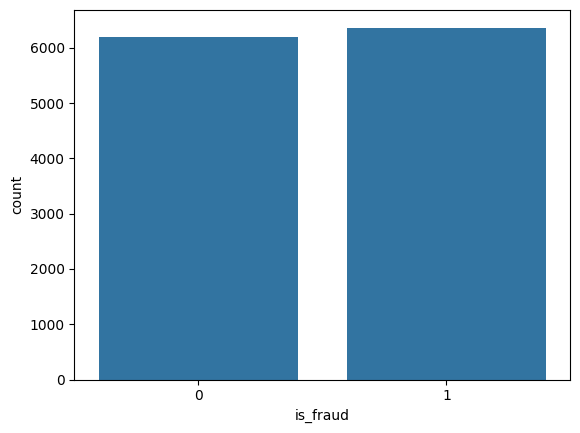

In [14]:
sns.countplot(x='is_fraud', data=df)